# Building Language models with N-Gram 

This project introduces language modeling by focusing on generating 90s rap lyrics. You will implement histogram N-gram models using the Natural Language Toolkit (NLTK) to analyze and understand word frequencies and distributions. This approach helps reveal linguistic patterns and the rhythmic flow characteristic of 90s rap.


#### Objectives

After completing this lab, you will be able to:

 - Utilize histogram N-gram models, implemented through the Natural Language Toolkit (NLTK), to analyze and understand word frequencies and distributions.
 




In [2]:
%%capture
import warnings
from tqdm import tqdm

warnings.simplefilter('ignore')
import time
from collections import OrderedDict

import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import string
import time

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
%capture

In [3]:
# Helper functions
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

## Language modeling

Language modeling is a foundational concept within the field of natural language processing (NLP) and artificial intelligence. **It involves the prediction of the likelihood of a sequence of words within a given language**. This method is **statistical** in nature and seeks to capture the patterns, structures, and relationships that exist between words in a given text corpus.

At its essence, a **language model strives to comprehend the probabilities associated with sequences of words**. This comprehension can be leveraged for a multitude of NLP tasks, including but not limited to text generation, machine translation, speech recognition, sentiment analysis, and more.

Let's consider the following song lyrics to determine if you can generate similar output using a given word.


In [4]:
song= """We are no strangers to love
You know the rules and so do I
A full commitments what Im thinking of
You wouldnt get this from any other guy
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
And if you ask me how Im feeling
Dont tell me youre too blind to see
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you"""

### Natural Language Toolkit (NLTK)
NLTK is indeed a widely-used open-source library in Python that is specifically designed for various natural language processing (NLP) tasks. It provides a comprehensive set of tools, resources, and algorithms that aid in the analysis and manipulation of human language data. 


### Tokenization

Tokenization, a fundamental concept within the realm of natural language processing (NLP), **involves the intricate process of breaking down a body of text into discrete units known as tokens.** These tokens can encompass words, phrases, sentences, or even individual characters, adapting based on the desired level of granularity for analysis. 

For the purpose of this project, you will focus on Word Tokenization, a prevalent technique. This technique treats each word in the text as an independent entity. Words, typically separated by spaces or punctuation marks, serve as the tokens in this approach. It's important to note that Word Tokenization exhibits versatile characteristics, including capitalization, symbols, and punctuation marks.

To achieve the goal, you will utilize the```word_tokenize```function. During this process, you will remove punctuation, symbols, and capital letters.

In [6]:
from nltk.tokenize import word_tokenize

# tokenizing
def preprocess(words):
    tokens = word_tokenize(words)
    tokens = [preprocess_string(w) for w in tokens]

    return [w.lower() for w in tokens if len(w) != 0 or not (w in string.punctuation)]

tokens = preprocess(song)

the outcome is a collection of tokens, wherein each element of the tokens pertains to the lyrics of the song, arranged in sequential order.

In [8]:
tokens[0:10]

['we', 'are', 'no', 'strangers', 'to', 'love', 'you', 'know', 'the', 'rules']

The frequency distribution of words in a sentence represents how often each word appears in that particular sentence. It provides a count of the occurrences of individual words, allowing you to understand which words are more common or frequent within the given sentence. Let's work with the following toy example:

```Text```: **I like dogs and I kinda like cats**

```Tokens```: **[I like, dogs, and, I, kinda, like, cats]**

The function```Count```will tally the occurrences of words in the input text.


$Count("I")=2$

$Count("like")= 2$

$Count("dogs")=1$

$Count("and")=1$

$Count("kinda")=1$

$Count("cats")=1$

$\text{Total words} =8$


Utilize```NLTK's FreqDist```to transform a frequency distribution of words. **The outcome is a Python dictionary where the keys correspond to words, and the values indicate the frequency of each word's appearance.** Please consider the provided example below.



In [10]:
# Create a frequency distribution of words
fdist = nltk.FreqDist(tokens)
fdist

FreqDist({'na': 40, 'gon': 38, 'you': 37, 'never': 36, 'and': 16, 'tell': 9, 'make': 8, 'say': 8, 'a': 7, 'give': 6, ...})

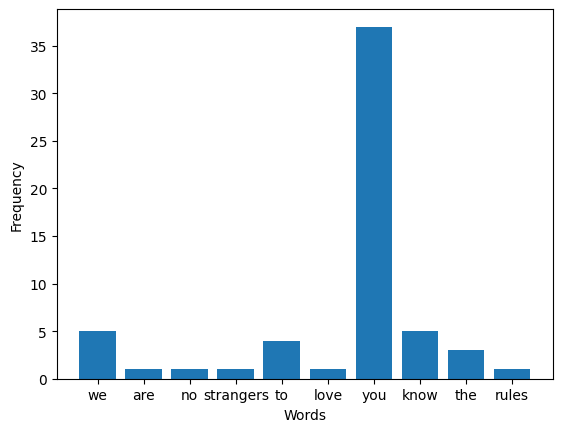

In [11]:
# ploting the top ten freqs

plt.bar(list(fdist.keys())[0:10],list(fdist.values())[0:10])
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

### unigram

Using NLTK you can normalize the frequency values by dividing them by the total count of each word to get a probability function. Now you will find the probability of each word.


In [12]:
C = sum(fdist.values())

C

385

In [14]:
# Finding the probability of the word 'strangers' 

fdist['strangers']/C

0.0025974025974025974

In [15]:
# Also, find each individual word by converting the tokens to a set.

vocabulary=set(tokens)

#### How unigram model predicts the next likely word

Let's consider a scenario from the above example **'I like tiramisu but I love cheesecake more'** where the unigram model is asked to predict the next word following the sequence **'I like'**.

If the highest probability among all words is **"I"** with a probability  0.25, then according to the model, the most likely next word after **'I like'** would be **'I'**. However, this prediction doesn't make sense at all. This highlights a significant limitation of the unigram model—it lacks context, and its predictions are entirely dependent on the word with the highest probability "I" in this case 

Even if multiple words have the same highest probabilities, it will randomly choose any one word out of all the options.


### Bigram model

Bigrams represent pairs of consecutive words in the given phrase, i.e., $(w_{t-1},w_t)$. Consider the following words from your example: "I like dogs and I kinda like cats."

The correct sequence of bigrams is:

$(I, like)$

$(like, dogs)$

$(dogs, and)$

$(and, I)$

$(I, kinda)$

$(kinda, like)$

$(like, cats)$


**2-Gram models**: Bigram models use conditional probability. The probability of a word depends only on the previous word, i.e., the conditional probability $(W_{t}, W_{t-1})$ is used to predict the likelihood of word $(W_t)$ following word $W_{t-1}$ in a sequence. You can calculate the conditional probability for a bigram model using the following steps.





This approach is, in fact, an approximation used to determine the most likely word $W_t$, given the words $W_{t-1}, W_{t-2}, \ldots, W_1$ in the sequence.

$P(W_t | W_{t-1}, W_{t-2}, \ldots, W_1) \approx P(W_t | W_{t-1})$

The conditional probability $P(W_t | W_{t-1})$ signifies the likelihood of encountering the word $W_t$, based on the context provided by the preceding word $W_{t-1}$. By employing this approximation, simplify the modeling process by assuming that the occurrence of the current word is mainly influenced by the most recent word in the sequence. In general, you have the capability to identify the most likely word.

$\hat{W_t} = \arg\max_{W_t} \left( P(W_t | W_{t-1}) \right)$


```bigrams``` is a function provided by the Natural Language Toolkit (NLTK) library in Python. This function takes a sequence of tokens as input and returns an iterator over consecutive pairs of tokens, forming bigrams.



In [16]:
bigrams = nltk.bigrams(tokens)
bigrams

<generator object bigrams at 0x3105a1b60>

In [17]:
my_bigrams=list(nltk.bigrams(tokens))

my_bigrams[0:10]

[('we', 'are'),
 ('are', 'no'),
 ('no', 'strangers'),
 ('strangers', 'to'),
 ('to', 'love'),
 ('love', 'you'),
 ('you', 'know'),
 ('know', 'the'),
 ('the', 'rules'),
 ('rules', 'and')]

Compute the frequency distribution of the bigram $C(w_{t},w_{t-1})$ using the NLTK function```bigrams```.


In [18]:
freq_bigrams  = nltk.FreqDist(nltk.bigrams(tokens))
freq_bigrams

FreqDist({('gon', 'na'): 38, ('never', 'gon'): 36, ('you', 'never'): 9, ('na', 'tell'): 8, ('make', 'you'): 8, ('na', 'give'): 6, ('give', 'you'): 6, ('you', 'up'): 6, ('up', 'never'): 6, ('na', 'let'): 6, ...})

The result is akin to a dictionary, where the key is a tuple containing the bigram.


In [19]:

freq_bigrams[('we', 'are')]

1

It is possible to provide you with the first 10 values of the frequency distribution.


In [20]:
for my_bigram in  my_bigrams[0:10]:
    print(my_bigram)
    print(freq_bigrams[my_bigram])

('we', 'are')
1
('are', 'no')
1
('no', 'strangers')
1
('strangers', 'to')
1
('to', 'love')
1
('love', 'you')
1
('you', 'know')
1
('know', 'the')
3
('the', 'rules')
1
('rules', 'and')
1


Here, you can generate the conditional distribution by normalizing the frequency distribution of unigrams. In this case, you are doing it for the word 'strangers' and then sorting the results:


In [21]:
word="strangers"
vocab_probabilities={}
for next_word in vocabulary:
    vocab_probabilities[next_word]=freq_bigrams[(word,next_word)]/fdist[word]

vocab_probabilities=sorted(vocab_probabilities.items(), key=lambda x:x[1],reverse=True)

In [22]:
# Print out the words that are more likely to occur.

vocab_probabilities[0:4]

[('to', 1.0), ('desert', 0.0), ('know', 0.0), ('you', 0.0)]

Create a function to calculate the conditional probability of $W_t$ given $W_{t-1}$, sort the results, and output them as a list.


In [23]:

def make_predictions(my_words, freq_grams, normlize=1, vocabulary=vocabulary):
    """
    Generate predictions for the conditional probability of the next word given a sequence.

    Args:
        my_words (list): A list of words in the input sequence.
        freq_grams (dict): A dictionary containing frequency of n-grams.
        normlize (int): A normalization factor for calculating probabilities.
        vocabulary (list): A list of words in the vocabulary.

    Returns:
        list: A list of predicted words along with their probabilities, sorted in descending order.
    """

    vocab_probabilities = {}  # Initialize a dictionary to store predicted word probabilities

    context_size = len(list(freq_grams.keys())[0])  # Determine the context size from n-grams keys

    # Preprocess input words and take only the relevant context words
    my_tokens = preprocess(my_words)[0:context_size - 1]

    # Calculate probabilities for each word in the vocabulary given the context
    for next_word in vocabulary:
        temp = my_tokens.copy()
        temp.append(next_word)  # Add the next word to the context

        # Calculate the conditional probability using the frequency information
        if normlize!=0:
            vocab_probabilities[next_word] = freq_grams[tuple(temp)] / normlize
        else:
            vocab_probabilities[next_word] = freq_grams[tuple(temp)] 
    # Sort the predicted words based on their probabilities in descending order
    vocab_probabilities = sorted(vocab_probabilities.items(), key=lambda x: x[1], reverse=True)

    return vocab_probabilities  # Return the sorted list of predicted words and their probabilities

Set $W_{t-1}$ to 'i' and then calculate all the values of $P(W_t | W_{t-1}=i)$.


In [24]:
my_words="are"

vocab_probabilities=make_predictions(my_words,freq_bigrams,normlize=fdist['i'])

In [25]:
vocab_probabilities[0:10]

[('no', 0.3333333333333333),
 ('desert', 0.0),
 ('know', 0.0),
 ('you', 0.0),
 ('never', 0.0),
 ('commitments', 0.0),
 ('let', 0.0),
 ('say', 0.0),
 ('inside', 0.0),
 ('understand', 0.0)]

The word with the highest probability, denoted as $\hat{W}_t$, is given by the first element of the list, this can be used as a simple autocomplete:


In [26]:
vocab_probabilities[0][0]

'no'

Generate a sequence using the bigram model by leveraging the preceding word (t-1) to predict and generate the subsequent word in the sequence.


In [27]:
my_song=""
for w in tokens[0:100]:
  my_word=make_predictions(w,freq_bigrams)[0][0]
  my_song+=" "+my_word

In [29]:
my_song

' know no strangers to say you never the game and desert long i just lie commitments what im feeling of you never get this from any other for i just wan na tell a never im feeling got ta make you never never gon na tell you never never gon na tell you never never gon na tell around and desert you never gon na tell you never never gon na tell goodbye never gon na tell a lie and desert you never known each other for so long your hearts been aching but youre too shy to say goodbye'

Create a sequence using the n-gram model by initiating the process with the first word in the sequence and producing an initial output. Subsequently, utilize this output as the basis for generating the next word in the sequence, i.e., you will give your model a word, then use the output to predict the next word and repeat.


In [30]:
my_song="i"

for i in range(100):
    my_word=make_predictions(my_word,freq_bigrams)[0][0]
    my_song+=" "+my_word

In [31]:
my_song

'i never gon na tell a lie and desert you never gon na tell a lie and desert you never gon na tell a lie and desert you never gon na tell a lie and desert you never gon na tell a lie and desert you never gon na tell a lie and desert you never gon na tell a lie and desert you never gon na tell a lie and desert you never gon na tell a lie and desert you never gon na tell a lie and desert you never gon na tell a lie and desert you never'

This method may not yield optimal results; consider the following:

$\hat{W_1}=\arg\max{W_1} \left( P(W_1 | W_{0}=\text{like})\right)$.

Upon evaluation, observe that the result for $\hat{W}_1$ includes both "dogs" and "cats" with equal likelihood.


## Trigram model
For the given example sentence: 'I like dogs and I kinda like cats'

$ (I, like, dogs) $

$(like, dogs, and) $

$(dogs, and, I)$

$(and, I, kinda)$

$(I, kinda, like)$

$(kinda, like, cats)$

Trigram models incorporate conditional probability as well. The probability of a word depends on the two preceding words. The conditional probability $P(W_t | W_{t-2}, W_{t-1})$ is utilized to predict the likelihood of word $W_t$ following the two previous words in a sequence. The context is $W_{t-2}, W_{t-1}$ and is of length 2. Let's compute the conditional probability for each trigram:

Calculate the trigram frequencies for each trigram: $Count(W_{t-2}, W_{t-1}, W_t)$

### Trigram frequency counts

$ \text{Count(I, like, dogs)} = 1 $

$ \text{Count(like, dogs, and)} = 1 $

$\text{Count(dogs, and, I)} = 1$

$ \text{Count(and, I, kinda)} = 1$

$ \text{Count(I, kinda, like)} = 1 $

$ \text{Count(kinda, like, cats)} = 1 $

The conditional probability $ P(w_{t} | w_{t-1}, w_{t-2})$ where $w_{t-1}$ and $w_{t-2}$ form the context, and the context size is 2.

To better understand how this outperforms the bigram model, let's compute the conditional probabilities with the context "I like":

$\hat{W_2}=\arg\max{W_2} \left( P(W_2 | W_{1}=like,W_{0}=I)\right)$

and for the words "cats" and "dogs":

$ P("dogs" | "like", "I") = \frac{Count(I, like, dogs)}{Total \ count \ of \ "I", "like"} = \frac{1}{1} = 1 $

$ P("cats" | "like", "I") = \frac{Count(I, like, cats)}{Total \ count \ of \ "I", "like"} = 0$

These probabilities signify the likelihood of encountering the third word in a trigram. Notably, the result $\hat{W}_2$ is "dogs," which seems to align better with the sequence.

The trigrams function is provided by the Natural Language Toolkit (NLTK) library in Python. This function takes a sequence of tokens as input, returns an iterator over consecutive token triplets, generating trigrams, and converts them into a frequency distribution.


In [32]:
freq_trigrams  = nltk.FreqDist(nltk.trigrams(tokens))
freq_trigrams

FreqDist({('never', 'gon', 'na'): 36, ('you', 'never', 'gon'): 9, ('gon', 'na', 'give'): 6, ('na', 'give', 'you'): 6, ('give', 'you', 'up'): 6, ('you', 'up', 'never'): 6, ('up', 'never', 'gon'): 6, ('gon', 'na', 'let'): 6, ('na', 'let', 'you'): 6, ('let', 'you', 'down'): 6, ...})

In [33]:
# Find the probability for each of the next words.

make_predictions("so do",freq_trigrams,normlize=freq_bigrams[('do','i')] )[0:10]

[('i', 1.0),
 ('desert', 0.0),
 ('know', 0.0),
 ('you', 0.0),
 ('never', 0.0),
 ('commitments', 0.0),
 ('let', 0.0),
 ('say', 0.0),
 ('inside', 0.0),
 ('understand', 0.0)]

In [34]:
my_song=""

w1=tokens[0]
for w2 in tokens[0:100]:
    gram=w1+' '+w2
    my_word=make_predictions(gram,freq_trigrams )[0][0]
    my_song+=" "+my_word
    w1=w2

In [35]:
my_song

' desert no strangers to love you know the game and so do i a full commitments what im thinking of you wouldnt get this from any other guy i just wan na tell a how im feeling got ta make you cry never gon na let you up never gon na let you down never gon na let around and desert you never gon na let you cry never gon na let goodbye never gon na let a lie and hurt you never known each other for so long your hearts been aching but youre too shy to say it'

There are various challenges associated with Histogram-Based Methods, some of which are quite straightforward. For instance, when considering the case of having N words in your vocabulary, a Unigram model would entail $N$ bins, while a Bigram model would result in $N^2$ bins and so forth.

N-gram models also encounter limitations in terms of contextual understanding and their ability to capture intricate word relationships. For instance, let's consider the phrases `I hate dogs`, `I don’t like dogs`, and **don’t like** means **dislike**. Within this context, a histogram-based approach would fail to grasp the significance of the phrase **don’t like** means **dislike**, thereby missing out on the essential semantic relationship it encapsulates.
